 ## TP n o 2 : k-plus proches voisins, analyse discriminante linéaire et régression logistique

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import neighbors, model_selection, datasets, metrics
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.base import BaseEstimator, ClassifierMixin
import math
from collections import Counter
from scipy.spatial.distance import cdist
from scipy.stats import mode
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

###        Data Generation

In [2]:
def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]


def rand_tri_gauss(n1=100, n2=100, n3=100, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.1, 0.1],
                   sigma2=[0.1, 0.1], sigma3=[0.1, 0.1]):
    """ Sample n1, n2 and n3 points from three Gaussian variables centered in mu1,
    mu2 and mu3 with std deviation sigma1, sigma2 and sigma3
    """
    ex1 = rand_gauss(n1, mu1, sigma1)
    ex2 = rand_gauss(n2, mu2, sigma2)
    ex3 = rand_gauss(n3, mu3, sigma3)
    X = np.vstack([ex1, ex2, ex3])
    y = np.hstack([np.ones(n1), 2. * np.ones(n2), 3 * np.ones(n2)])

    ind = np.random.permutation(n1 + n2 + n3)
    np.random.shuffle(ind)
    return X[ind, :], y[ind]


def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """ Sample a dataset clown  with
    n1 points and noise std deviation sigma1 for the first class, and
    n2 points and noise std deviation sigma2 for the second one
    """
    x0 = np.random.randn(n1, 1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1, 1)
    x2 = np.hstack([sigma2 * np.random.randn(n2, 1),
                    sigma2 * np.random.randn(n2, 1) + 2.])
    X = np.vstack([np.hstack([x0, x1]), x2])
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]


def rand_checkers(n1=100, n2=100, sigma=0.1):
    """ Sample n1 and n2 points from a noisy checker"""
    nbp = int(np.floor(n1 / 8))
    nbn = int(np.floor(n2 / 8))
    xapp = np.reshape(np.random.rand((nbp + nbn) * 16), [(nbp + nbn) * 8, 2])
    yapp = np.ones((nbp + nbn) * 8)
    idx = 0
    for i in range(-2, 2):
        for j in range(-2, 2):
            if (((i + j) % 2) == 0):
                nb = nbp
            else:
                nb = nbn
                yapp[idx:(idx + nb)] = [(i + j) % 3 + 1] * nb

            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.arange((nbp + nbn) * 8)
    np.random.shuffle(ind)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :2]), np.array(res[ind, 2])


### Displaying labeled data

In [3]:
symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=np.reshape(color_blind_list[i], (1, -1)), s=80,
                    marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

### Displaying tools for the Frontiere

In [4]:


def frontiere(f, data, step=50, cmap_choice=cm.coolwarm, tiny=False):
    """ trace la frontiere pour la fonction de decision f"""
    xmin, xmax = data[:, 0].min() - 1., data[:, 0].max() + 1.
    ymin, ymax = data[:, 1].min() - 1., data[:, 1].max() + 1.
    xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) * 1. / step),
                         np.arange(ymin, ymax, (ymax - ymin) * 1. / step))
    z = f(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.imshow(z, origin='lower', interpolation="nearest",
               extent=[xmin, xmax, ymin, ymax], cmap=cmap_choice)
    if tiny:
        plt.xticks([])
        plt.yticks([])
    else:
        plt.colorbar()

def frontiere_new(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True):
    """trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f([vec]) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[label_num]],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

### Algorithms and functions

In [5]:


class ErrorCurve(object):
    def __init__(self, k_range=None, weights='uniform'):
        if k_range is None:
            k_range = list(range(1, 6))
        self.k_range = k_range
        self.weights = weights

    def fit_curve(self, X, y, Xtest, ytest):
        def error_func(k):
            knn = neighbors.KNeighborsClassifier(n_neighbors=k,
                                                 weights=self.weights)
            knn.fit(X, y)
            error = np.mean(knn.predict(Xtest) != ytest)
            return error

        errors = list(map(error_func, self.k_range))
        self.errors = np.array(errors)
        self.y = y

    def plot(self, marker='o', maketitle=True, **kwargs):
        plt.plot(self.k_range, self.errors, marker=marker, **kwargs)
        plt.xlabel("K")
        plt.ylabel("Test error")
        if maketitle:
            plt.title("number of training points : %d" % len(self.y))


class LOOCurve(object):
    """Leave-One-Out (LOO) curve"""
    def __init__(self, k_range=None, weights='uniform'):
        if k_range is None:
            k_range = list(range(1, 6))
        self.k_range = k_range
        self.weights = weights

    def fit_curve(self, X, y, n_iter=200, random_state=1):
        def score_func(k):
            n_samples = len(X)
            # Selon la verson de scikit-learn : shuffleSplit prend en argument
            # 'niter ' ou niterations'. De plus, l'argument test_size peut ne
            # pas etre reconnu. Il est recommande de consulter
            # help(model_selection.ShuffleSplit) pour connaitre la liste
            # des arguments reconnus par votre version de sickitlearn.
            loo = model_selection.ShuffleSplit(n_iter,
                                                test_size=1,
                                                train_size=n_samples-1,
                                                random_state=random_state)
            knn = neighbors.KNeighborsClassifier(n_neighbors=k,
                                                 weights=self.weights)
            scores = model_selection.cross_val_score(estimator=knn,
                                                      X=X, y=y,
                                                      cv=loo)
            return np.mean(scores)

        scores = list(map(score_func, self.k_range))
        self.cv_scores = np.array(scores)
        self.y = y

    def plot(self, marker='o', maketitle=True, **kwargs):
        plt.plot(self.k_range, self.cv_scores, marker=marker, **kwargs)
        plt.xlabel("K")
        plt.ylabel("Leave One Out Score (1-error rate)")
        if maketitle:
            plt.title("number of training points : %d" % (len(self.y) - 1))


### Génération artificielle de données

### Question 1 : Étude les fonctions rand_bi_gauss, rand_tri_gauss, rand_clown et rand_checkers

In [6]:
n1 = 100
n2 = 100
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigmas1 = [0.9, 0.9]
sigmas2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigmas1, sigmas2)
X2, y2 = rand_tri_gauss(50, 50, 50, [1, 1],[-1, -1],[1, -1],[0.9, 0.9],[0.9, 0.9],[0.9, 0.9])
X3, y3 = rand_clown()
X4, y4 = rand_checkers(150,150)

In [57]:
X1[y1==-1].shape
np.mean(X1[y1==-1], axis=0)

array([-1.00479073, -0.99964826])

In [58]:
len(X1)

2000

In [7]:
(X1.shape)

(200, 2)

- Ces fonctions renvoient des échantillons de données distribués suivant une loi gaussienne. 

- La dernière colonne correspond aux étiquettes des données (labels)

### Question 2 : Affichage des jeux de données générés

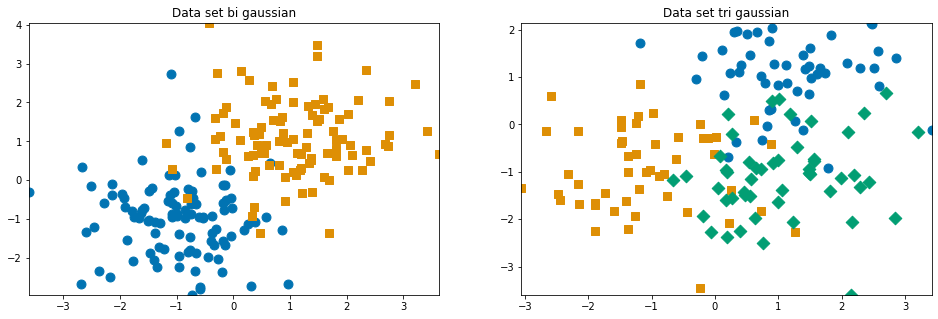

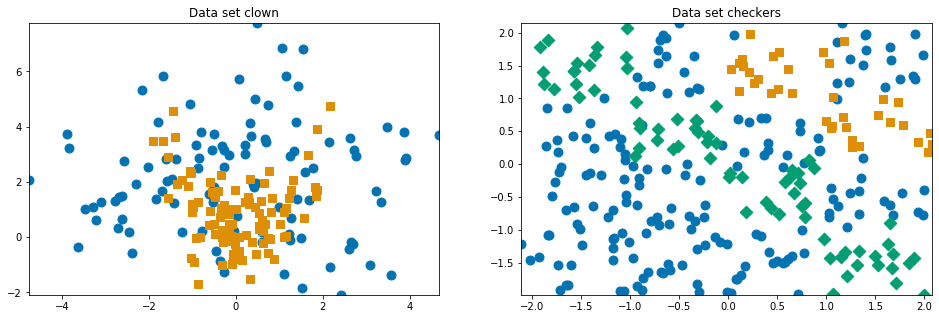

In [8]:
plt.figure(1, figsize=(25, 5))
plt.subplot(131)
plt.title('Data set bi gaussian')
plot_2d(X1, y1)
plt.subplot(132)
plt.title('Data set tri gaussian')
plot_2d(X2, y2)

plt.figure(2, figsize=(25, 5))
plt.subplot(131)
plt.title('Data set clown')
plot_2d(X3, y3)
plt.subplot(132)
plt.title('Data set checkers')
plot_2d(X4, y4)
plt.show()

### Question 3:

### Question 4 : Définition de la classe KNNClassifier

In [9]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    """ Homemade kNN classifier class """
            
    def __init__(self, n_neighbors=1):
        # Complete the mehtod
        self.n_neighbors = n_neighbors
        
    def fit(self, X, y):
        self.Xtrain = X
        self.ytrain = y

    def predict(self, X):
        # Complete the mehtod  
        self.Xtest = X
        predictions = []
        
        #Calcul des distances
        distances = cdist(self.Xtest, self.Xtrain, "euclidean")
        sort_distances = np.argsort(distances, axis =1)
        
        # n distances les plus proches
        near_dist =  sort_distances[:,:self.n_neighbors]
        predictions_all = self.ytrain[near_dist]
        
        # valeurs prédites
        for i in range(predictions_all.shape[0]):
            pred_win = Counter(predictions_all[i,:]).most_common(1)[0][0]
            predictions.append(pred_win)

        return predictions

In [10]:
Xtrain = X2[0:75]
ytrain = y2[0:75]
Xtest = X2[75:150]

In [11]:
clf = KNNClassifier(5)

In [12]:
mod_knn = clf.fit(Xtrain,ytrain)

In [13]:
y_test_pred = clf.predict(Xtest)
print(y_test_pred)

[3.0, 3.0, 3.0, 3.0, 3.0, 1.0, 1.0, 2.0, 3.0, 2.0, 3.0, 3.0, 2.0, 3.0, 1.0, 1.0, 3.0, 1.0, 3.0, 2.0, 1.0, 3.0, 3.0, 1.0, 3.0, 1.0, 1.0, 1.0, 3.0, 1.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 3.0, 2.0, 3.0, 3.0, 3.0, 1.0, 1.0, 3.0, 1.0, 2.0, 1.0, 2.0, 3.0, 1.0, 2.0, 2.0, 1.0, 3.0, 1.0, 3.0, 1.0, 3.0, 3.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0]


#### Comparaison avec KNeighborsClassifier

In [14]:
model_neigh = KNeighborsClassifier(5)
model_neigh.fit(Xtrain,ytrain)
y_neigh_pred = model_neigh.predict(Xtest)
y_neigh_pred

array([3., 3., 3., 3., 3., 1., 1., 2., 3., 2., 3., 3., 2., 3., 1., 1., 3.,
       1., 2., 2., 1., 3., 3., 1., 3., 1., 1., 1., 3., 1., 3., 3., 3., 3.,
       2., 2., 1., 1., 1., 2., 3., 2., 3., 3., 3., 1., 1., 3., 1., 2., 1.,
       2., 3., 1., 2., 2., 1., 3., 1., 3., 1., 3., 3., 1., 1., 1., 2., 2.,
       2., 1., 2., 2., 1., 1., 1.])

In [15]:
diff = y_test_pred - y_neigh_pred
print('la différence entre KNNClassifier et KNeighborsClassifier est de :' + str(sum(diff)))
print('Notre modèle KNNClassifier colle bien avec celui de scikit-learn')

la différence entre KNNClassifier et KNeighborsClassifier est de :1.0
Notre modèle KNNClassifier colle bien avec celui de scikit-learn


### Question 5

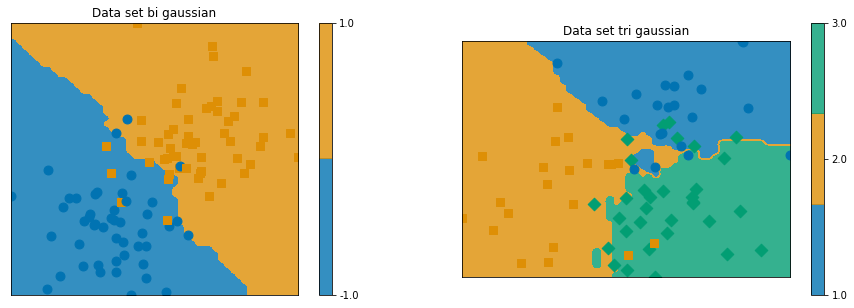

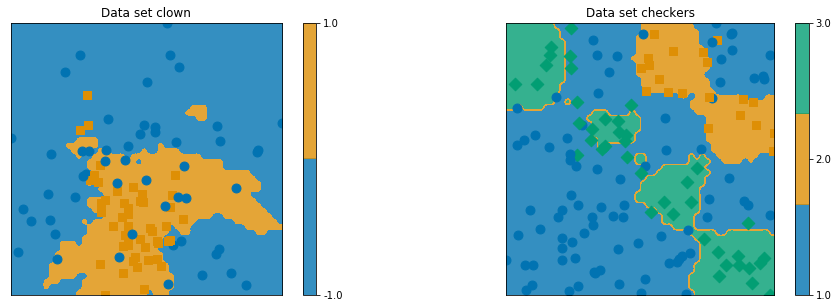

In [16]:
def mod_predit(x):
    model =  model_kneigh.predict(x)
    return model

plt.figure(1, figsize=(25, 5))
plt.subplot(131)
model_kneigh = KNeighborsClassifier(5)
model_kneigh.fit(X1[::2], y1[::2])
plt.title('Data set bi gaussian')
frontiere_new(mod_predit, X1[1::2], y1[1::2])

plt.figure(1, figsize=(25, 5))
plt.subplot(132)
model_kneigh = KNeighborsClassifier(5)
model_kneigh.fit(X2[::2], y2[::2])
plt.title('Data set tri gaussian')
frontiere_new(mod_predit, X2[1::2], y2[1::2])

plt.figure(2, figsize=(25, 5))
plt.subplot(131)
model_kneigh = KNeighborsClassifier(5)
model_kneigh.fit(X3[::2], y3[::2])
plt.title('Data set clown')
frontiere_new(mod_predit, X3[1::2], y3[1::2])

plt.figure(2, figsize=(25, 5))
plt.subplot(132)
model_kneigh = KNeighborsClassifier(5)
model_kneigh.fit(X4[::2], y4[::2])
plt.title('Data set checkers')
frontiere_new(mod_predit, X4[1::2], y4[1::2])

### Question 6

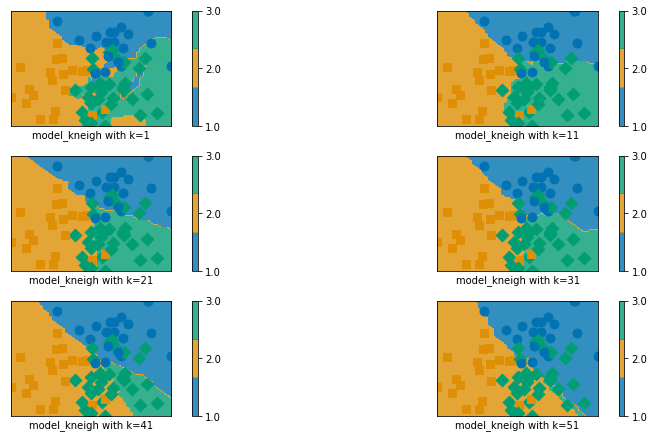

In [17]:
plt.figure(3, figsize=(12, 8))
iterate=0
for n_neighbors in range(1, 60, 10):
    iterate=iterate+1
    model_kneigh = KNeighborsClassifier(n_neighbors)
    model_kneigh.fit(X2[::2],y2[::2])
    plt.subplot(4, 2, iterate)
    plt.xlabel('model_kneigh with k=%d' % n_neighbors)
    frontiere_new(mod_predit, X2[1::2], y2[1::2])


plt.tight_layout()
plt.show()

On constate que les frontières sont complexes quand le nombre de voisins k est petit et
deviennent de plus en plus simples avec l'augmentation de k (nombre de voisins).

### Question 7

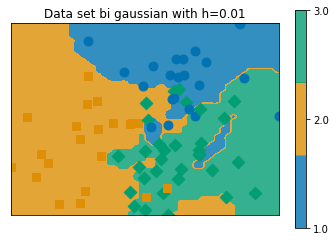

In [18]:
def _weights_funct(dist):
    h = 0.01
    w = (np.exp(-dist**2/h))
    return w
model_kneigh = KNeighborsClassifier(n_neighbors = 7, weights = _weights_funct )
model_kneigh.fit(X2[::2], y2[::2])
plt.title('Data set bi gaussian with h=0.01')
frontiere_new(mod_predit, X2[1::2], y2[1::2])

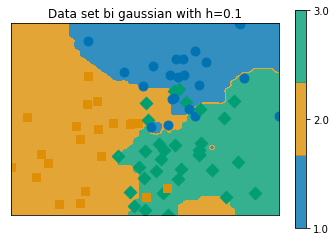

In [19]:
def _weights_funct(dist):
    h = 0.1
    w = (np.exp(-dist**2/h))
    return w
model_kneigh = KNeighborsClassifier(n_neighbors = 7, weights = _weights_funct )
model_kneigh.fit(X2[::2], y2[::2])
plt.title('Data set bi gaussian with h=0.1')
frontiere_new(mod_predit, X2[1::2], y2[1::2])

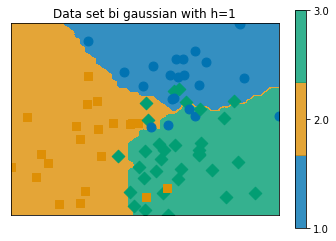

In [20]:
def _weights_funct(dist):
    h = 1
    w = (np.exp(-dist**2/h))
    return w
model_kneigh = KNeighborsClassifier(n_neighbors = 7, weights = _weights_funct )
model_kneigh.fit(X2[::2], y2[::2])
plt.title('Data set bi gaussian with h=1')
frontiere_new(mod_predit, X2[1::2], y2[1::2])

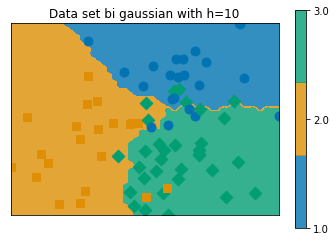

In [21]:
def _weights_funct(dist):
    h = 10
    w = (np.exp(-dist**2/h))
    return w
model_kneigh = KNeighborsClassifier(n_neighbors = 7, weights = _weights_funct )
model_kneigh.fit(X2[::2], y2[::2])
plt.title('Data set bi gaussian with h=10')
frontiere_new(mod_predit, X2[1::2], y2[1::2])


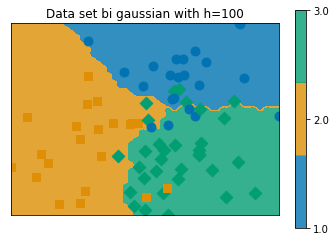

In [22]:
def _weights_funct(dist):
    h = 100
    w = (np.exp(-dist**2/h))
    return w
model_kneigh = KNeighborsClassifier(n_neighbors = 7, weights = _weights_funct )
model_kneigh.fit(X2[::2], y2[::2])
plt.title('Data set bi gaussian with h=100')
frontiere_new(mod_predit, X2[1::2], y2[1::2])

On note un grand lissage des frontières entre h=0.1 et h=1. Au-délà de h=10, on ne remarque plus de grandes différences avec notre jeu de données.

### Question 8:

In [23]:
model_kneigh = KNeighborsClassifier(n_neighbors = 1)
model_kneigh.fit(X2[::2], y2[::2])
taux_erreur_app = 1 - model_kneigh.score(X2[::2], y2[::2])
print(" le taux d'erreur sur les données d'apprentissage est: " + str(round(taux_erreur_app,3)*100) + "%")

 le taux d'erreur sur les données d'apprentissage est: 0.0%


In [24]:
taux_erreur_test = 1 - model_kneigh.score(X2[1::2], y2[1::2])
print(" le taux d'erreur sur les données de test est: " + str(round(taux_erreur_test,3)*100) + "%")

 le taux d'erreur sur les données de test est: 21.3%


### Question 9: 

No handles with labels found to put in legend.


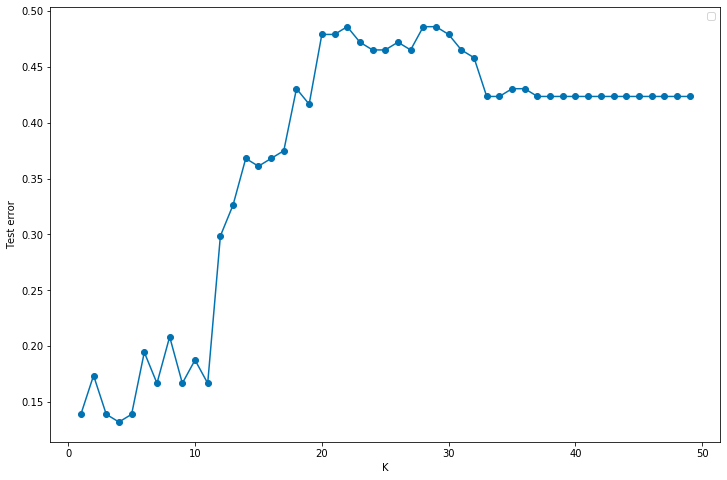

In [25]:
plt.figure(figsize=(12,8))
X4_error = ErrorCurve(k_range=list(range(1,50)))
X4_error.fit_curve(X4[::2],y4[::2], X4[1::2],y4[1::2])
X4_error.plot(maketitle=False)
plt.legend()

### Question 10:

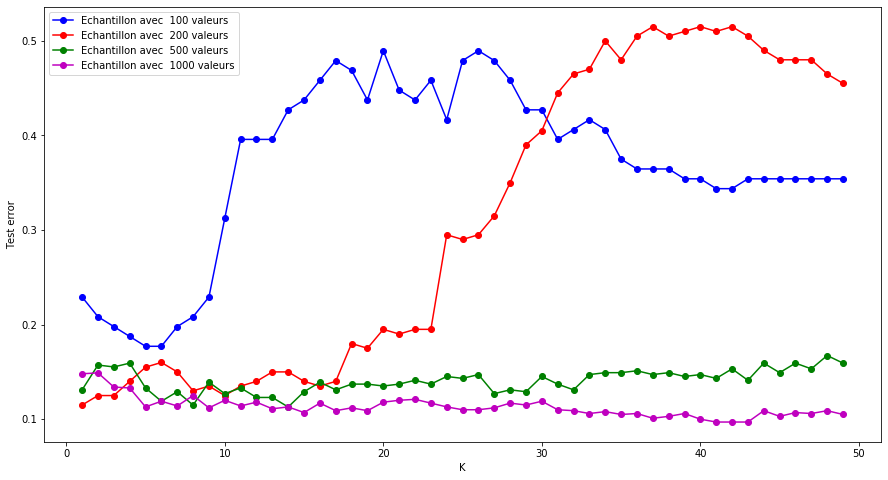

In [26]:
echantillons=[100,200,500,1000]
color=['b','r','g','m','c']
plt.figure(4, figsize=(15, 8))
for iteration, ech in enumerate(echantillons):
    label='Echantillon avec  ' +str(ech) +' valeurs'
    n1 = ech
    n2 = ech
    X4, y4 = rand_checkers(n1,n2)
    X4_train = X4[::2]
    y4_train = y4[::2]
    X4_test = X4[1::2]
    y4_test = y4[1::2]
    X4_error = ErrorCurve(k_range=list(range(1,50)))
    X4_error.fit_curve(X4_train,y4_train, X4_test,y4_test)
    color_ = color[iteration]
    
    X4_error.plot(maketitle=False,color=color_, label=label)
    plt.legend()


On observe que l'erreur diminue considérablement au fur et à mersure que la taille de notre échantillon augmente.

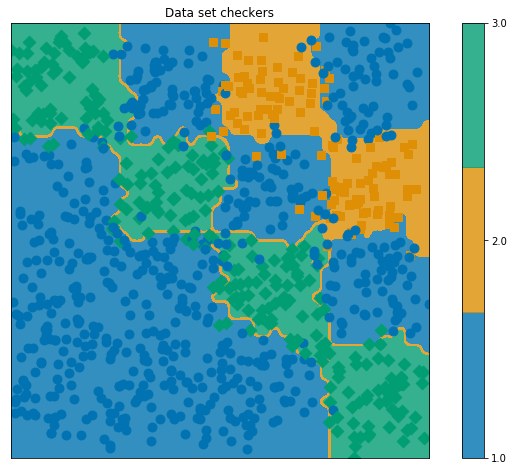

In [27]:
plt.figure(figsize=(12,8))
n=1000
X4, y4 = rand_checkers(n,n)
model_kneigh = KNeighborsClassifier(5)
model_kneigh.fit(X4[::2], y4[::2])
plt.title('Data set checkers')
frontiere_new(mod_predit, X4[1::2], y4[1::2])

### Question 11 

 - **Avanatages:**
        Le principal avantage de la méthode des plus proches voisins est son interprétabilité
        
 - **Inconvénients:**
         on principal est son temps de calculs qui semble être conséquent lorsque le nombre d'échantillons augmente.

### Question 12

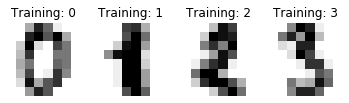

In [28]:
digits = datasets.load_digits()

images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

Text(0, 0.5, 'Density')

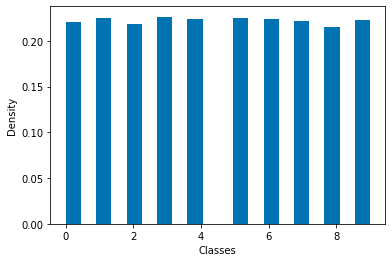

In [29]:
label1=[]
image1=[]
for index, (image, label) in enumerate(images_and_labels):
    label1.append(label)
    
plt.hist(label1 , bins = 20, density = True)
plt.xlabel("Classes")
plt.ylabel("Density")

In [30]:
nbre_ech = len(digits.images)
data = digits.images.reshape((nbre_ech, -1))

model_kneigh= KNeighborsClassifier(n_neighbors=30)

model_kneigh.fit(data[::2], digits.target[::2])
# Now predict the value of the digit on the second half:

target_true= digits.target[1::2]
target_predict = model_kneigh.predict(data[1::2])

In [31]:
taux_erreur_digit = 1 - model_kneigh.score(data[1::2], digits.target[1::2])
print(" le taux d'erreur sur les données de test est: " + str(round(taux_erreur_digit,3)*100) + "%")

 le taux d'erreur sur les données de test est: 5.6000000000000005%


In [32]:
print (1 - metrics.r2_score(target_true,target_predict))

0.167062818336163


### Question 13

In [33]:
matrice_confusion =  metrics.confusion_matrix(target_true, target_predict)
print("La matrice de confusion est: " + str(matrice_confusion))

La matrice de confusion est: [[88  0  0  0  0  0  0  0  0  0]
 [ 0 88  0  0  0  0  1  0  0  0]
 [ 1  1 84  0  0  0  0  1  4  0]
 [ 0  0  1 85  0  2  0  2  3  0]
 [ 0  0  0  0 87  0  0  0  1  0]
 [ 0  0  0  0  0 87  1  0  0  3]
 [ 0  0  0  0  0  0 90  0  0  0]
 [ 0  0  0  0  0  0  0 91  0  0]
 [ 0  5  2  1  0  2  1  0 75  0]
 [ 0  5  0  0  5  1  0  6  1 73]]


### Question 14

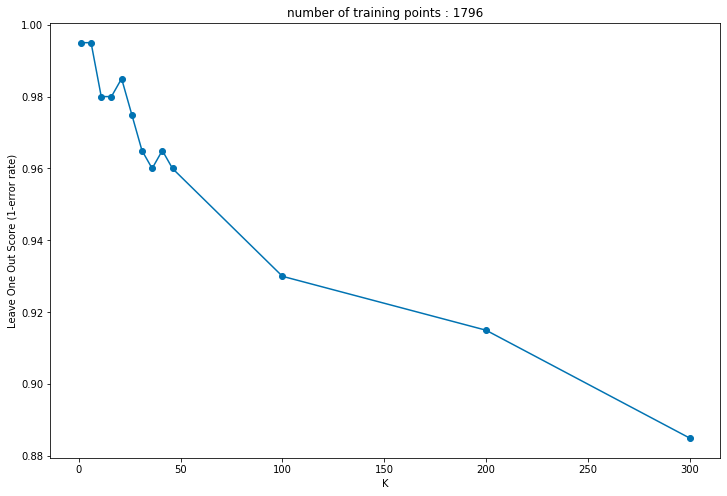

In [34]:
plt.figure(figsize=(12,8))
values_k = [1,6,11,16,21,26,31,36,41,46,100,200,300]
CV_digits = LOOCurve(k_range = values_k)
CV_digits.fit_curve(data, digits.target)
CV_digits.plot()

### Question 15

$$ \mathbb{P}\{Y=+1|X=x\} = \frac{\mathbb{P}\{Y=+1, X=x\}}{\mathbb{P}\{X=x\}}$$$$ \mathbb{P}\{Y=+1|X=x\} = \frac{\mathbb{P}\{X=x|Y=+1\} \mathbb{P}\{Y=+1\} }{\mathbb{P}\{X=x\} }$$$$ \mathbb{P}\{Y=+1|X=x\} = \frac{f_+ \pi_+}{\mathbb{P}\{X=x\} }$$$ \mathbb{P}\{Y=+1|X=x\} = \frac{f_+ \pi_+}{(\mathbb{P}\{X=x|Y=+1\}\mathbb{P}\{Y= +1\} + \mathbb{P}\{X=x|Y=-1\}\mathbb{P}\{Y= -1\}) }$$$\mathbb{P}\{Y=+1|X=x\} = \frac{f_+ \pi_+}{(f_+\pi_+ + f_-\pi_-)}$$Respectivement: $$ \mathbb{P}\{Y=-1|X=x\} = \frac{f_- (1-\pi_+)}{\mathbb{P}\{X=x\} }$$
$$\mathbb{P}\{Y=+1|X=x\} = \frac{f_- (1-\pi_+)}{(f_+\pi_+ + f_-\pi_-)}$$

### Question 16

$$log:$$ $$log\left(\frac{\mathbb{P}\{Y=+1|X=x\}}{\mathbb{P}\{Y=-1|X=x\}}\right) = log\left(\frac{f_+\pi_+}{f_-(1-\pi_+)}\right)$$$$ \frac{f_+}{f_-} =  exp\left\{\frac{1}{2}\left[(x-\mu_-)^T \Sigma^{-1} (x-\mu_-) - \left((x-\mu_+)^T \Sigma^{-1} (x-\mu_+)\right)  \right]\right\}$$$$ \frac{f_+}{f_-} =  exp\left\{-x^T\Sigma^{-1}\mu_-  + x^T\Sigma^{-1}\mu_+ + \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- - \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+ \right\}$$$$ \frac{f_+}{f_-} =  exp\left\{x^T\Sigma^{-1}(\mu_+ - \mu_-) + \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- - \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+ \right\}$$$$ log\left(\frac{\mathbb{P}\{Y=+1|X=x\}}{\mathbb{P}\{Y=-1|X=x\}}\right) = x^T\Sigma^{-1}(\mu_+ - \mu_-) + \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- - \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+  + log\left(\frac{\pi_+}{(1-\pi_+)}\right)$$

### Question 17

Si $Y$ prend la valeur 1, alors
$$P(Y=1|X=x) > P(Y=-1|X=x)$$Par conséquent
$$log\left(\frac{\mathbb{P}\{Y=+1|X=x\}}{\mathbb{P}\{Y=-1|X=x\}}\right) > 1$$

### Question 18

In [61]:
class LDAClassifier(BaseEstimator, ClassifierMixin):
    # Complete the mehtod
    def fit(self, X, y):       
        X_pos = X[y == 1]
        n = len(X)
        m = len(X_pos)
        mean_x_pos = np.mean(X_pos, axis=0)
        Cov_pos = np.cov(np.transpose(X_pos))
        
        X_neg = X[y == -1]
        mean_x_neg = np.mean(X_neg, axis=0)
        Cov_neg = np.cov(np.transpose(X_neg))
        
        inv_cov_tot = np.linalg.inv((1/(n-2))*( (m-1)* Cov_pos + (n-m-1)* Cov_neg))
        
        s1 = np.dot(np.transpose(mean_x_pos),inv_cov_tot)
        s2 = np.dot(np.transpose(mean_x_neg),inv_cov_tot)
        
        self.alpha = 0.5*(np.dot(s1,mean_x_pos)  - np.dot(s2,mean_x_neg)) + np.log(1- m/n) - np.log(m/n)
        self.beta =  np.dot(inv_cov_tot,mean_x_pos-mean_x_neg)
        return self
    
    def predict(self, X):
        y_pred_final=[]
        for i in range(len(X)):
            X_pred = X[i]
            b = np.dot(np.transpose(X_pred), self.beta)
            if (b>self.alpha):
                y_pred = 1
            else:
                y_pred = -1
            y_pred_final.append(y_pred)
        return np.array(y_pred_final)         

### Question 19

In [95]:
n1 = 1000
n2 = 100
sigmas1 = [0.9, 0.9]
sigmas2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigmas1, sigmas2)

In [96]:
model_lda_sc = LDAClassifier()
model_lda_sc.fit(X1[::2],y1[::2])
y_pred_lda_sc = model_lda_sc.predict(X1[1::2])

taux_err_lda_sc = 1- model_lda_sc.score(X1[1::2],y1[1::2])

print("Le taux d'erreur obtenu avec la LDAClassifier est : " + str(round(taux_err_lda_sc*100, 3)) + " %")

Le taux d'erreur obtenu avec la LDAClassifier est : 3.273 %


In [97]:
model_lda=LinearDiscriminantAnalysis()
model_lda.fit(X1[::2],y1[::2])
y_pred_lda = model_lda.predict(X1[1::2])


taux_err_lda =1- model_lda.score(X1[1::2],y1[1::2])

print("Le taux d'erreur obtenu avec la LinearDiscriminantAnalysis de scikit est : " + str(round(taux_err_lda*100, 3)) + " %")

Le taux d'erreur obtenu avec la LinearDiscriminantAnalysis de scikit est : 3.273 %


In [98]:
diff_lda_lda_sc = (y_pred_lda_sc - y_pred_lda).sum()
diff_lda_lda_sc

0.0

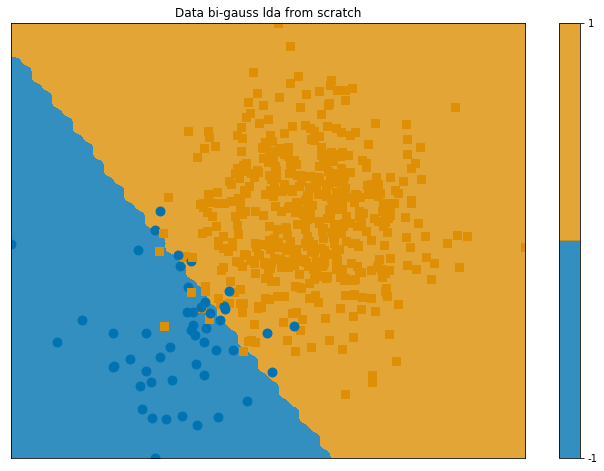

In [99]:
def mod_predit_lda(x):
    model =  model_lda_sc.predict(x)
    return model

plt.figure(figsize=(12,8))
plt.title('Data bi-gauss lda from scratch')
frontiere_new(mod_predit_lda, X1[1::2], y1[1::2])

### Question 20

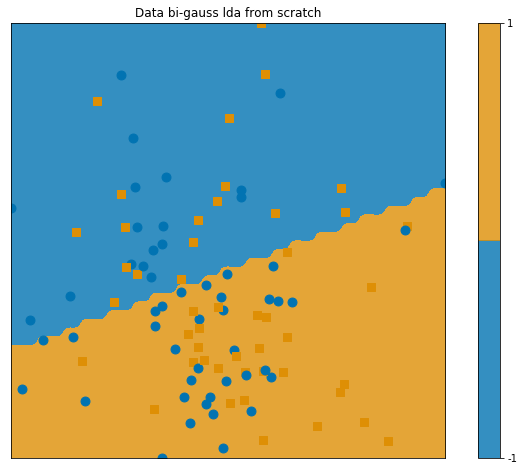

In [100]:
model_lda_sc = LDAClassifier()
model_lda_sc.fit(X3[::2],y3[::2])

plt.figure(figsize=(12,8))
plt.title('Data bi-gauss lda from scratch')
frontiere_new(mod_predit_lda, X3[1::2], y3[3::2])

### Question 21

In [131]:
model_lr= linear_model.LogisticRegression(solver='liblinear', multi_class='auto')
model_lr.fit(X1[::2],y1[::2])
y1_predict_lr = model_lr.predict(X1[1::2])

In [132]:
model_lda=LinearDiscriminantAnalysis()
model_lda.fit(X1[::2],y1[::2])
y1_predict_lda = model_lda.predict(X1[1::2])

In [133]:
diff_lr_lda = y1_predict_lr - y1_predict_lda
print('la différence entre LogisticRegression et LinearDiscriminantAnalysis est de :' + str(sum(diff_lr_lda)))

la différence entre LogisticRegression et LinearDiscriminantAnalysis est de :0.0


In [134]:
taux_err_lr =1- model_lr.score(X1[1::2],y1[1::2])
taux_err_lda =1- model_lda.score(X1[1::2],y1[1::2])

print("Le taux d'erreur obtenu avec la Logistic regresssion est : " + str(round(taux_err_lr*100, 3)) + " %")
print("Le taux d'erreur obtenu avec la LinearDiscriminantAnalysis est : " + str(round(taux_err_lda*100, 3)) + " %")

Le taux d'erreur obtenu avec la Logistic regresssion est : 0.0 %
Le taux d'erreur obtenu avec la LinearDiscriminantAnalysis est : 0.0 %


In [135]:
n = 1000
X1, y1 = rand_bi_gauss(n, n)
model_lr.fit(X1[::2],y1[::2])
y1_predict_lr1000 = model_lr.predict(X1[1::2])

In [136]:
model_lda.fit(X1[::2],y1[::2])
y1_predict_lda1000 = model_lda.predict(X1[1::2])

In [137]:
taux_err_lr1000 =1- model_lr.score(X1[1::2],y1[1::2])
taux_err_lda1000 =1- model_lda.score(X1[1::2],y1[1::2])

print("Le taux d'erreur obtenu avec la Logistic regresssion est : " + str(round(taux_err_lr1000,3)*100) + " %")
print("Le taux d'erreur obtenu avec la LinearDiscriminantAnalysis est : " + str(round(taux_err_lda1000,3)*100) + " %")

Le taux d'erreur obtenu avec la Logistic regresssion est : 0.0 %
Le taux d'erreur obtenu avec la LinearDiscriminantAnalysis est : 0.0 %


### Question 22

In [138]:
model_lr.coef_

array([[2.92960148, 2.92810996]])

In [139]:
model_lr.intercept_

array([-0.03543383])

In [140]:
model_lda.coef_

array([[204.28983632, 197.49253654]])

In [141]:
model_lda.intercept_

array([-0.20830083])

### Question 23

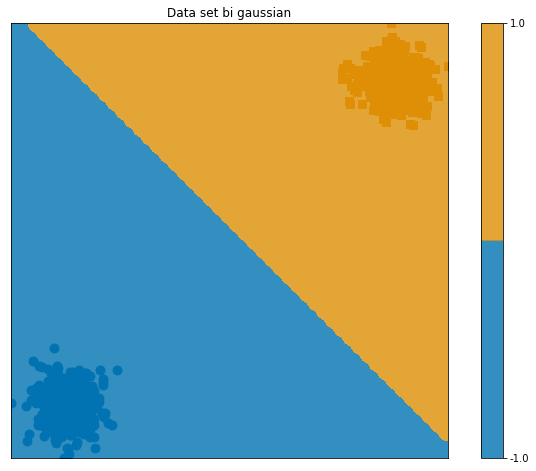

In [142]:
def mod_predit(x):
    model =  model_lr.predict(x)
    return model

plt.figure(figsize=(12, 8))
model_lr.fit(X1[::2], y1[::2])
plt.title('Data set bi gaussian')
frontiere_new(mod_predit, X1[1::2], y1[1::2])

### Question 24

In [143]:
model_lr.fit(data[::2], digits.target[::2])
# Now predict the value of the digit on the second half:
target_true= digits.target[1::2]
target_predict_lr = model_lr.predict(data[1::2])

In [145]:
taux_erreur_digit_lr = 1 - model_lr.score(data[1::2], digits.target[1::2])
print(" le taux d'erreur sur les données de test est: " + str(round(taux_erreur_digit_lr*100,3)) + "%")

 le taux d'erreur sur les données de test est: 6.013%


In [150]:
print (str(round((1 - (metrics.r2_score(target_true,target_predict_lr)))*100,3)) + " %")

15.959 %
